# Is Sympy really 'slow'?
I don't want to be a bad carpenter who blames his tools. Here're my attempts at understanding why my Sympy code is slow. The technical specs of my computer may have a lot to do with the long time things are taking to run, though, any techniques I discover to speed up computation will have a speed up on any system I suppose. 

Ultimately my goal is to have integral and linear algebra routines that can run at sub-second speed, and preferrably a few ms. 

## Potential things to try out 

* ~~I may have been using the wrong Python version of Theano. The [docs](https://theano-pymc.readthedocs.io/en/latest/requirements.html) say official support for Theano is only there for Python <3.6.~~ 
    * ~~install Sympy, Theano nd pyMC3~~ *This doesn't work because Theano didn't seem to recognise 'external' sympy functions, eg. legendre*
    
* With ```lambdify``` use the 'mpmath' module as a backend. This *really* sped up computations, in comparison to the default (sympy?) backend module. 

* ~~Linux specific: change the 'niceness'of the process and so the CPU spends more time on the code.~~~

## Latest realisation
* I've been using the 'normal' Hankel function instead of the spherical Hankel function. This is probably the main reason why my results are off all the time!!!!!

In [1]:
#from joblib import Parallel, delayed
#from joblib import wrap_non_picklable_objects
from gmpy2 import *
import matplotlib.pyplot as plt
import mpmath
from mpmath import mpf
dps = 300; mpmath.mp.dps = dps
import numpy as np
#from scipy.special import jv as bessel_firstkind
from symengine import * 
import sympy
from sympy import jn,yn ,symbols, legendre, sin, cos, tan, summation, I, oo, diff, pi, sqrt
from sympy import factor_terms, Matrix, besselj, bessely, Piecewise
from sympy import Abs, lambdify, integrate, expand,integrate, Integral
from sympy.printing.theanocode import theano_function
from sympy.utilities.autowrap import autowrap
import tqdm
x, alpha, gamma, index, k, m,n,p, r1, R, theta, y, z = symbols('x alpha gamma index k m n p r1 R theta,y,z')
from sympy import N, cse

from sympy.printing.theanocode import theano_function
num_sumterms = 50

In [2]:
from sympy import besselj

In [3]:
I*yn(10,0.5)

I*yn(10, 0.5)

In [4]:
o = (pi/(2*z))**0.5

In [5]:
sph_bessel1 = besselj(n+1/2,z)*(pi/(2*z))**0.5
sph_bessel2 = bessely(n+1/2,z)*(pi/(2*z))**0.5
sph_hankel2 = sph_bessel1 - I*sph_bessel2
#sph_hankel2 = lambdify([n, p], sph_bessel1(n,p)-I*sph_bessel2(n,p), 'mpmath')

In [6]:
sph_bessel2

0.707106781186548*pi**0.5*(1/z)**0.5*bessely(n + 0.5, z)

In [7]:
r1 = (R*cos(alpha))/cos(theta)

In [8]:
subs_dict = {'alpha':mpmath.pi/18, 'k':5,'R':mpf(0.1), 'm':20,'n':10}

In [9]:
Lm_expr = legendre(m,cos(theta))*(r1**2/R**2)*tan(theta)

Lm = Integral(Lm_expr, (theta,0,alpha))#.doit(meijerg=True)

In [10]:
Lmexpr_func = lambdify([m, R, alpha,theta], Lm_expr, 'mpmath')
Lm_func = lambdify([m, R, alpha], Lm, 'mpmath')

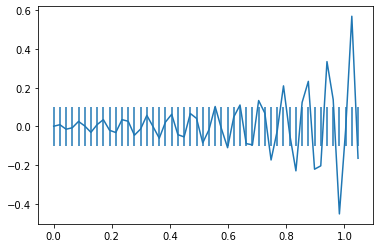

In [11]:
thetas = np.linspace(0,np.pi/3,50)
lmfunc = [Lmexpr_func(80,subs_dict['R'],subs_dict['alpha'],each) for each in thetas]
plt.figure()
plt.plot(thetas, lmfunc)
plt.vlines(thetas,-0.1,0.1)

In [12]:
%%time
Lm.subs(subs_dict)

CPU times: user 10.9 ms, sys: 798 µs, total: 11.7 ms
Wall time: 11.5 ms


Integral(0.969846310392954192027054638662365734968104067132232316545143331387110605497944729474872944918974033730960817398294313288485348932880651035479140561807004293999950264158603233101774083020590157375568357766537288398870110357001140760571205464234359534333409829879224962958951982263287877818111235427506*(34461632205*cos(theta)**20/262144 - 83945001525*cos(theta)**18/131072 + 347123925225*cos(theta)**16/262144 - 49589132175*cos(theta)**14/32768 + 136745788725*cos(theta)**12/131072 - 29113619535*cos(theta)**10/65536 + 15058768725*cos(theta)**8/131072 - 557732175*cos(theta)**6/32768 + 334639305*cos(theta)**4/262144 - 4849845*cos(theta)**2/131072 + 46189/262144)*tan(theta)/cos(theta)**2, (theta, 0, 0.17453292519943295769236907684886127134428718885417254560971914401710091146034494436822415696345094822123044925073790592483854692275281012398474218934047117319168245015010769561697553581238605305168788691271172087032963589602642490187704350918173343939698047594019224158946968481378963297

In [13]:
# eqn 12.107
Kmn_expr = legendre(n, cos(theta))*legendre(m, cos(theta))*sin(theta)
#Kmn = Integral(Kmn_expr, (theta, alpha, pi))#.as_sum(num_sumterms,'midpoint')

In [14]:
legendre_1stderiv = diff(legendre(n,z),z)
# when m != n
num_legendre_term1 = legendre(m,cos(alpha))*legendre_1stderiv.subs({'z':cos(alpha)})
num_legendre_term2 = legendre(n,cos(alpha))*legendre_1stderiv.subs({'n':m,'z':cos(alpha)})
eqn70_mnoteqn = sin(alpha)*(num_legendre_term1-num_legendre_term2)/(m*(m+1)-n*(n+1))
#
summn_funcn = legendre(index,cos(alpha))*(legendre(index,cos(alpha))*cos(alpha)-legendre(index+1,cos(alpha)))
# substituting 'j' for 'index' because j is also used for sqrt(-1) all through the book!!

# --- THERE'S PROBABLY AN ERROR IN THE M==N CASE BECAUSE THE SUMMATION GOES FROM 1 -- M-1 , AND W
# THEN THE SUMMATION IS FROM 1 -- 0. NEED TO CHECK IF THE NEW VERSION ALSO HAS THIS WEIRD TERM?
meqn_sumterm = 2*summation(summn_funcn, (index,1,m-1))
eqn70_meqn = (1+ legendre(m,cos(alpha))**2 + meqn_sumterm)/(2*m+1)

In [15]:
Kmn = Piecewise((eqn70_mnoteqn,m>n),(eqn70_mnoteqn,m<n), (eqn70_meqn,True), )
Kmn_func = lambdify([m,n,alpha],Kmn,'mpmath')

In [16]:
Kmn

Piecewise(((-m*(cos(alpha)*legendre(m, cos(alpha)) - legendre(m - 1, cos(alpha)))*legendre(n, cos(alpha))/(cos(alpha)**2 - 1) + n*(cos(alpha)*legendre(n, cos(alpha)) - legendre(n - 1, cos(alpha)))*legendre(m, cos(alpha))/(cos(alpha)**2 - 1))*sin(alpha)/(m*(m + 1) - n*(n + 1)), (m > n) | (m < n)), ((legendre(m, cos(alpha))**2 + 2*Sum((cos(alpha)*legendre(index, cos(alpha)) - legendre(index + 1, cos(alpha)))*legendre(index, cos(alpha)), (index, 1, m - 1)) + 1)/(2*m + 1), True))

In [17]:
pt1_postterm = legendre(n,cos(theta))*cos(theta)
alternate_hankels = n*sph_hankel2.subs({'n':n-1, 'z':k*r1})-(n+1)*sph_hankel2.subs({'n':n+1, 'z':k*r1})
Imn_pt1 = alternate_hankels*pt1_postterm

pt2_preterm = n*(n+1)*sph_hankel2.subs({'z':k*r1})
alternate_legendres = pt2_preterm*(legendre(n-1,cos(theta))-legendre(n+1,cos(theta)))/(k*r1)
Imn_pt2 = pt2_preterm*alternate_legendres


whole_postterm = legendre(m,cos(theta))*(r1**2/R**2)*tan(theta)

Imn_term = (Imn_pt1 + Imn_pt2)*whole_postterm
#Imn = Integral(Imn_term,(theta,0,alpha)).as_sum(50)
Imn = Integral(Imn_term,(theta,0,alpha))
# Imn_part2 = n*(n+1)*sph_hankel2(n, k*r1)*(legendre(n-1, cos(theta)-legendre(n+1, cos(theta))))/k*r1
#Imn_parts = expand(Imn_part1+Imn_part2)
#Imn_expr = expand(sympy.simplify(Imn_parts*legendre(m,cos(theta))*(r1**2/R**2)*tan(theta)))
#Imn = Integral(Imn_expr, (theta, 0, alpha))#.doit(meijerg=True)
Imn_term_func = lambdify([m,n,k,R,alpha,theta], Imn_term, 'mpmath')
Imn_func = lambdify([m,n,k,R,alpha],Imn,'mpmath')
#Imn2_func = lambdify([m,n,k,R,alpha],Imn2,'mpmath')

In [18]:

def imn_quad_value(params):
    variables = ['m','n','k','R','alpha']    
    imn_onlytheta = Imn_term.subs({each: params[each] for each in variables})
    imn_onlytheta_f = lambdify([theta],imn_onlytheta,'mpmath')
    # try breaking 0-alpha into 10 parts if the error is  too high - with mpmath.linspace?
    return mpmath.quad(imn_onlytheta_f,[0,params['alpha']],error=True)

In [19]:
mv,nv = 2,5
npts = 100
imn_values = mpmath.matrix(1,npts)
angles = np.linspace(0,float(subs_dict['alpha']),npts)
for i,each in enumerate(angles):
    imn_values[i] = Imn_term_func(mv,nv,subs_dict['k'],subs_dict['R'],subs_dict['alpha'],each)
real_imn = [each.real for each in imn_values]
imag_imn = [each.imag for each in imn_values]
abs_imn = [abs(each) for each in imn_values]

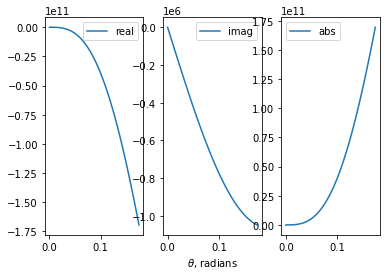

In [20]:
plt.figure()
plt.subplot(131)
plt.plot(angles, real_imn,label='real');plt.legend()
plt.subplot(132)
plt.plot(angles, imag_imn,label='imag');plt.legend()
plt.xlabel('$\\theta$, radians')
plt.subplot(133)
plt.plot(angles, abs_imn,label='abs');plt.legend()


### Broadly speaking, the Imn function is fairly smooth, and so numerical integration shouldn't be such a problem?

In [21]:
b = -I*Lm
b_func = lambdify([m,alpha], b,'mpmath')

In [22]:
frequency = 50*10**3 # kHz
vsound = 330 # m/s
wavelength = vsound/frequency
alpha_value = mpmath.pi/3 # 60 degrees --> pi/3
k_value = 2*np.pi/(wavelength)
ka = 5
a_value = ka/k_value 
R_value = a_value/mpmath.sin(alpha_value) # m


In [23]:
Nv = 12 + int(2*ka/sin(alpha_value))
M_matrix = mpmath.matrix(Nv,Nv)
b_matrix = mpmath.matrix(Nv,1)


In [24]:
params = {'k':k_value, 'a':a_value, 'R':R_value, 'alpha':alpha_value}

In [25]:
mmn_hankels = n*sph_hankel2.subs({'n':n-1,'z':k*R})-(n+1)*sph_hankel2.subs({'n':n+1,'z':k*R})
mmn_hankels_func = lambdify([n,k,R], mmn_hankels,'mpmath')

In [26]:
all_quaderrors = []
for i in tqdm.trange(Nv):
    for j in range(Nv):
        params['m'],params['n'] = i,j
        Imn_value,quad_error = imn_quad_value(params)
        all_quaderrors.append(quad_error)
        Kmn_value = Kmn_func(i,j,params['alpha'])
        numerator_hankels = mmn_hankels_func(j,params['k'],params['R'])
        numerator = Imn_value+ numerator_hankels*Kmn_value
        denom = 2*j+1
        M_matrix[i,j] = numerator/denom


100%|██████████| 23/23 [1:37:09<00:00, 253.46s/it]


In [27]:
all_quaderrors

[mpf('1.0e-313'),
 mpf('1.0e-609'),
 mpf('1.0e-609'),
 mpf('1.0e-609'),
 mpf('1.0e-607'),
 mpf('1.0e-606'),
 mpf('1.0e-606'),
 mpf('1.0e-604'),
 mpf('1.0e-602'),
 mpf('1.0e-596'),
 mpf('1.0e-592'),
 mpf('1.0e-588'),
 mpf('1.0e-582'),
 mpf('1.0e-581'),
 mpf('1.0e-574'),
 mpf('1.0e-568'),
 mpf('1.0e-563'),
 mpf('1.0e-558'),
 mpf('1.0e-552'),
 mpf('1.0e-547'),
 mpf('1.0e-541'),
 mpf('1.0e-536'),
 mpf('1.0e-531'),
 mpf('1.0e-314'),
 mpf('1.0e-610'),
 mpf('1.0e-610'),
 mpf('1.0e-609'),
 mpf('1.0e-608'),
 mpf('1.0e-607'),
 mpf('1.0e-607'),
 mpf('1.0e-604'),
 mpf('1.0e-602'),
 mpf('1.0e-596'),
 mpf('1.0e-592'),
 mpf('1.0e-588'),
 mpf('1.0e-582'),
 mpf('1.0e-580'),
 mpf('1.0e-574'),
 mpf('1.0e-568'),
 mpf('1.0e-563'),
 mpf('1.0e-558'),
 mpf('1.0e-552'),
 mpf('1.0e-547'),
 mpf('1.0e-541'),
 mpf('1.0e-536'),
 mpf('1.0e-531'),
 mpf('1.0e-313'),
 mpf('1.0e-611'),
 mpf('1.0e-611'),
 mpf('1.0e-610'),
 mpf('1.0e-609'),
 mpf('1.0e-608'),
 mpf('1.0e-607'),
 mpf('1.0e-605'),
 mpf('1.0e-602'),
 mpf('1.0e

In [28]:
help(mpmath.lu_solve)

Help on method lu_solve in module mpmath.matrices.linalg:

lu_solve(A, b, **kwargs) method of mpmath.ctx_mp.MPContext instance
    Ax = b => x
    
    Solve a determined or overdetermined linear equations system.
    Fast LU decomposition is used, which is less accurate than QR decomposition
    (especially for overdetermined systems), but it's twice as efficient.
    Use qr_solve if you want more precision or have to solve a very ill-
    conditioned system.
    
    If you specify real=True, it does not check for overdeterminded complex
    systems.



In [29]:
for each_m in range(Nv):
    #M_matrix[each_m, each_n] = M_mn_func(each_m, each_n, k_value, R_value, alpha_value)
    b_matrix[each_m,:] = b_func(each_m, alpha_value)


In [30]:
#a_matrix = mpmath.lu_solve(M_matrix,b_matrix) -# fast but dirty 
a_matrix,res = mpmath.qr_solve(M_matrix,b_matrix) # slow but reliable

In [31]:
legendre_func = lambdify((m, x), legendre(m, x),'mpmath')

In [32]:

def d_theta(angle,k_v,R_v,alpha_v,An):
    num = 4 
    N_v = An.rows
    denom  = (k_v**2)*(R_v**2)*mpmath.sin(alpha_v)**2
    part1 = num/denom
    jn_matrix = np.array([1j**f for f in range(N_v)])
    legendre_matrix = np.array([legendre(n_v, np.cos(angle)) for n_v in range(N_v)])
    part2_matrix = np.column_stack((An, jn_matrix, legendre_matrix))
    part2 = np.sum(np.apply_along_axis(lambda X: X[0]*X[1]*X[2], 1, part2_matrix))
    rel_level = - part1*part2
    return rel_level

def d_zero(k_v,R_v,alpha_v,An):
    num = 4 
    N_v = An.rows
    denom  = (k_v**2)*(R_v**2)*mpmath.sin(alpha_v)**2
    part1 = num/denom
    jn_matrix = np.array([1j**f for f in range(N_v)])
    part2_matrix = np.column_stack((An, jn_matrix))
    part2 = np.sum(np.apply_along_axis(lambda X: X[0]*X[1], 1, part2_matrix))
    rel_level = - part1*part2
    return rel_level

def relative_directionality_db(angle,k_v,R_v,alpha_v,An):
    off_axis = d_theta(angle,k_v,R_v,alpha_v,An)
    on_axis = d_zero(k_v,R_v,alpha_v,An)
    rel_level = 20*mpmath.log10(abs(off_axis/on_axis))
    return rel_level

In [33]:

angles = np.linspace(0,2*np.pi,100)
dirnlty = [relative_directionality_db(angle_v, k_value, R_value,alpha_value,a_matrix) for angle_v in angles]


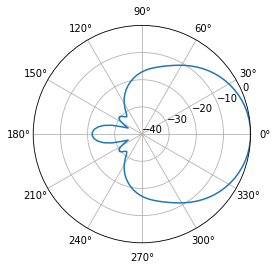

In [34]:
plt.figure()
a0 = plt.subplot(111, projection='polar')
plt.plot(angles, dirnlty)
plt.ylim(-40,0);plt.yticks([0,-10,-20,-30,-40]);
plt.xticks(np.radians(np.arange(0,360,30)));